# Identifying Habitable Exoplanets using Machine Learning
## Data Science Capstone Project of BBM467, 2022 Fall

#### Hikmet Güner, Deniz Erkin Kasaplı
#### 21946179, 21946328

Clustering exoplanets using machine learning in order to gather insight about potentially habitable planets outside of our solar system.
Considering the fact that even the closest planets outside of the solar system are unreachable, there is no way to classify a planet as habitable or not with accuracy. However, there are some key elements which are considered necessary for habitability. The aim of this project is to gather insight of how grouping planets, without making any habitability indicing calculations, could affect filtering based on habitability. The dataset used for this project is directly fetched from NASA's exoplanet archive, which will be clustered for further analysis. The results could be utilized to filter out false positives, saving time and resources which would be spent on those planets otherwise.

## Table of Content

[Problem](#problem)   
[Data Understanding](#data_understanding)   
[Data Preparation](#data_preparation)   
[Modeling](#modeling)   
[Evaluation](#evaluation)   
[References](#references)   


## Problem <a class="anchor" id="problem"></a>

Describe the problem here. What are the questions you are trying to solve?

Considering the fact that the tools used to identify exoplanets are biased, it seems plausible to begin the analysis without any prior knowledge of the planet, where the algorithm only groups planets that correleate. Then, from these correleations, more insight could be gained on placing key plantes which are known to be habitable or close to be habitable, such as Earth and Mars. However, these results should not be taken at face value, they exist simply to filter unwanted planets or false positives as much as possible.

Imports required for the notebook

In [115]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import warnings
import math

from matplotlib.lines import Line2D
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial import ConvexHull
from scipy import interpolate
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.preprocessing import normalize
from sklearn.neighbors import KernelDensity
from sklearn.metrics.cluster import rand_score
from sklearn.decomposition import PCA

Reading the data, Supressing chained assignment warning, since chained assignment works six to seven times faster, supressing future warnings

In [116]:
warnings.simplefilter(action='ignore', category=FutureWarning)
df = pd.read_csv("new.csv",header=0, index_col=0)
pd.set_option('mode.chained_assignment', None)

**Necessary function for column information**

In [117]:
def get_cols_info():
    n_col = 6
    fig, axes = plt.subplots(nrows=(len(df.columns) // n_col), ncols=n_col, figsize=(18,18))
    ax_index = 0
    fig.suptitle(f'Distribution of Columns Visualized')
    for col in df.columns:
        sample = df[col].sort_values()
        #attributes
        mean = sample.mean()
        std = sample.std()
        col_max = sample.max()
        col_min = sample.min()
        sem = sample.sem()
        sample -= mean 
         
        pdf = stats.norm.pdf(sample,mean,std)

        ax = axes[ax_index // n_col][ax_index % n_col]
        #normalize plot
        ax.hist(sample, bins=20, density=True, label="Data", color='gray')
        ax.plot(sample, pdf, 'r-', label="PDF")                   
        sns.kdeplot(data=sample,ax=ax, label = 'KDE')                                       

        ax.legend(loc='best')

        x_ticks = np.arange(-4*std, 4.1*std, std)                                  
        x_labels = [f"{i}std" for i in range(-4,5)]    
        ax.grid(True, alpha=0.3, linestyle="--")
        ax.set_title(col)
        ax_index += 1
        #box plot
    fig.tight_layout()
    df.loc[:,~df.columns.str.contains('err') & ~df.columns.str.contains('flag')].plot(kind='box',title='Box Plot', showfliers = False, figsize= (22,6))

## Data Understanding<a class="anchor" id="data_understanding"></a>

The dataset used is directly from NASAs exoplanet archive, which the user "SATHYANARAYAN RAO" on Kaggle has compiled and created a comma-separated value (.csv) version of it.

The dataset has fields about planetary attributes, stellar attributes and star system based attributes. Some of the fields have labels, some of them have hyper links but the majority of them are scalar. Further analysis can be found in the column analysis spreadsheet

The dataset could be reached from the link <a href=https://www.kaggle.com/datasets/sathyanarayanrao89/nasa-exoplanetary-system>here</a> ( <a href="exoplanets.csv">.csv format</a>)

You can reach the column analysis spreadsheet from <a href="columns.xlsx">here</a>

In [118]:
df.shape

(5243, 164)

In [119]:
df.columns

Index(['pl_name', 'hostname', 'pl_letter', 'hd_name', 'hip_name', 'tic_id',
       'gaia_id', 'sy_snum', 'sy_pnum', 'sy_mnum',
       ...
       'sy_tmag', 'sy_tmag_reflink', 'sy_kepmag', 'sy_kepmag_reflink',
       'pl_nnotes', 'st_nphot', 'st_nrvc', 'st_nspec', 'pl_nespec',
       'pl_ntranspec'],
      dtype='object', length=164)

### Columns that will stay 

In [120]:
df = df[['pl_name','hostname','sy_snum',
'sy_pnum',
'sy_mnum',
'pl_orbper',
'pl_orbsmax',
'pl_rade',
'pl_radj',
'pl_bmasse',
'pl_bmassj',
'pl_dens',
'pl_orbeccen',
'pl_insol',
'pl_eqt',
'pl_orbincl',
'pl_trandep',
'pl_ratdor',
'pl_orbtper',
'pl_orblper',
'st_spectype',
'st_teff',
'st_rad',
'st_mass',
'st_lum',
'st_logg',
'st_age',
'st_dens',
'st_radv',
'cb_flag',
'pl_trueobliq',
'pl_occdep',
'pl_projobliq',
'sy_icmag',
'st_rotp',
'sy_umag',
'st_vsin',
'pl_rvamp',
'sy_zmag',
'sy_imag',
'sy_gmag',
'sy_rmag',
'sy_kepmag',
'pl_imppar',
'pl_ratror',
'pl_trandur',
'pl_tranmid',
'sy_w1mag',
'sy_w4mag',
'sy_w2mag',
'sy_w3mag',
'sy_bmag',
'sy_gaiamag',
'sy_jmag',
'sy_tmag',
'sy_hmag',
'sy_vmag',
'sy_kmag',
'sy_dist'
]]

# csv dosyasındaki pl_bmassprov yok karar verilirse o eklenebilir

In [121]:
df.shape

(5243, 59)

In [122]:
df.isnull().sum().to_frame()

,0
pl_name,0
hostname,0
sy_snum,0
sy_pnum,0
sy_mnum,0
pl_orbper,191
pl_orbsmax,286
pl_rade,17
pl_radj,18
pl_bmasse,23


## Data Preparation<a class="anchor" id="data_preparation"></a>

### Checking for duplicates in the dataframe

In [123]:
temp_table = df.pivot_table(index = ['pl_name'], aggfunc ='size')
for i in temp_table:
    if i != 1:
        print(i.index)

In [124]:
num_of_duplicates = len(df) - len(df.drop_duplicates())
num_of_duplicates

0

In [125]:
all_columns = df.columns
all_columns

Index(['pl_name', 'hostname', 'sy_snum', 'sy_pnum', 'sy_mnum', 'pl_orbper',
       'pl_orbsmax', 'pl_rade', 'pl_radj', 'pl_bmasse', 'pl_bmassj', 'pl_dens',
       'pl_orbeccen', 'pl_insol', 'pl_eqt', 'pl_orbincl', 'pl_trandep',
       'pl_ratdor', 'pl_orbtper', 'pl_orblper', 'st_spectype', 'st_teff',
       'st_rad', 'st_mass', 'st_lum', 'st_logg', 'st_age', 'st_dens',
       'st_radv', 'cb_flag', 'pl_trueobliq', 'pl_occdep', 'pl_projobliq',
       'sy_icmag', 'st_rotp', 'sy_umag', 'st_vsin', 'pl_rvamp', 'sy_zmag',
       'sy_imag', 'sy_gmag', 'sy_rmag', 'sy_kepmag', 'pl_imppar', 'pl_ratror',
       'pl_trandur', 'pl_tranmid', 'sy_w1mag', 'sy_w4mag', 'sy_w2mag',
       'sy_w3mag', 'sy_bmag', 'sy_gaiamag', 'sy_jmag', 'sy_tmag', 'sy_hmag',
       'sy_vmag', 'sy_kmag', 'sy_dist'],
      dtype='object')

### Dropping the columns which have more missing value than 1000

In [126]:
col_will_drop = []

for i in all_columns:
    if df[i].isnull().sum() > 1000:
        col_will_drop.append(i)

col_will_drop

['pl_insol',
 'pl_eqt',
 'pl_orbincl',
 'pl_trandep',
 'pl_ratdor',
 'pl_orbtper',
 'pl_orblper',
 'st_spectype',
 'st_age',
 'st_radv',
 'pl_trueobliq',
 'pl_occdep',
 'pl_projobliq',
 'sy_icmag',
 'st_rotp',
 'sy_umag',
 'st_vsin',
 'pl_rvamp',
 'sy_zmag',
 'sy_imag',
 'sy_gmag',
 'sy_rmag',
 'sy_kepmag',
 'pl_imppar',
 'pl_ratror',
 'pl_trandur',
 'pl_tranmid']

In [127]:
df = df.drop(columns = col_will_drop)
df.columns

Index(['pl_name', 'hostname', 'sy_snum', 'sy_pnum', 'sy_mnum', 'pl_orbper',
       'pl_orbsmax', 'pl_rade', 'pl_radj', 'pl_bmasse', 'pl_bmassj', 'pl_dens',
       'pl_orbeccen', 'st_teff', 'st_rad', 'st_mass', 'st_lum', 'st_logg',
       'st_dens', 'cb_flag', 'sy_w1mag', 'sy_w4mag', 'sy_w2mag', 'sy_w3mag',
       'sy_bmag', 'sy_gaiamag', 'sy_jmag', 'sy_tmag', 'sy_hmag', 'sy_vmag',
       'sy_kmag', 'sy_dist'],
      dtype='object')

In [128]:
df.shape

(5243, 32)

#### Getting the amount of missing columns per row

In [129]:
s = df.set_index('pl_name').isna().groupby('pl_name').sum().sum(axis=1)
for i in df['pl_name']:
    df.loc[df['pl_name'] == i,'empty_col_count'] = s[i]


In [130]:
df.head()

,pl_name,hostname,sy_snum,sy_pnum,sy_mnum,pl_orbper,pl_orbsmax,pl_rade,pl_radj,pl_bmasse,...,sy_w3mag,sy_bmag,sy_gaiamag,sy_jmag,sy_tmag,sy_hmag,sy_vmag,sy_kmag,sy_dist,empty_col_count
rowid,,,,,,,,,,,,,,,,,,,,,
1,11 Com b,11 Com,2,1,0,326.030000,1.290000,12.1,1.08,6165.60000,...,2.358,5.726,4.44038,2.943,3.83790,2.484,4.72307,2.282,93.1846,1.0
2,11 UMi b,11 UMi,1,1,0,516.219970,1.530000,12.3,1.09,4684.81420,...,1.894,6.382,4.56216,2.876,3.82294,2.091,5.01300,1.939,125.3210,1.0
3,14 And b,14 And,1,1,0,185.840000,0.830000,12.9,1.15,1525.50000,...,2.719,6.256,4.91781,3.019,4.32140,2.608,5.23133,2.331,75.4392,1.0
4,14 Her b,14 Her,1,2,0,1765.038901,2.773069,12.6,1.12,2586.74645,...,4.721,7.495,6.38300,5.158,5.86310,4.803,6.61935,4.714,17.9323,0.0
5,16 Cyg B b,16 Cyg B,3,1,0,798.500000,1.660000,13.5,1.20,565.73740,...,4.926,6.876,6.06428,4.993,5.62810,4.695,6.21500,4.651,21.1397,0.0


In [131]:
print('Max:\t', df['empty_col_count'].max())
print('Min:\t',df['empty_col_count'].min())
print('Total:\t',len(df.columns))

Max:	 19.0
Min:	 0.0
Total:	 33


In [132]:
df[df['pl_name'] == 'TRAPPIST-1 e']

,pl_name,hostname,sy_snum,sy_pnum,sy_mnum,pl_orbper,pl_orbsmax,pl_rade,pl_radj,pl_bmasse,...,sy_w3mag,sy_bmag,sy_gaiamag,sy_jmag,sy_tmag,sy_hmag,sy_vmag,sy_kmag,sy_dist,empty_col_count
rowid,,,,,,,,,,,,,,,,,,,,,
4966,TRAPPIST-1 e,TRAPPIST-1,1,7,0,6.101013,0.02925,0.92,0.082,0.692,...,NaN,NaN,15.6451,11.354,13.8529,10.718,17.02,10.296,12.429889,5.0


**Dropping rows have missing values more than 5**

In [133]:
df = df[df['empty_col_count'] < 10]
df[df['pl_name'] == 'TRAPPIST-1 e']

,pl_name,hostname,sy_snum,sy_pnum,sy_mnum,pl_orbper,pl_orbsmax,pl_rade,pl_radj,pl_bmasse,...,sy_w3mag,sy_bmag,sy_gaiamag,sy_jmag,sy_tmag,sy_hmag,sy_vmag,sy_kmag,sy_dist,empty_col_count
rowid,,,,,,,,,,,,,,,,,,,,,
4966,TRAPPIST-1 e,TRAPPIST-1,1,7,0,6.101013,0.02925,0.92,0.082,0.692,...,NaN,NaN,15.6451,11.354,13.8529,10.718,17.02,10.296,12.429889,5.0


In [134]:
df[df['pl_name'] == 'TRAPPIST-1 e']

,pl_name,hostname,sy_snum,sy_pnum,sy_mnum,pl_orbper,pl_orbsmax,pl_rade,pl_radj,pl_bmasse,...,sy_w3mag,sy_bmag,sy_gaiamag,sy_jmag,sy_tmag,sy_hmag,sy_vmag,sy_kmag,sy_dist,empty_col_count
rowid,,,,,,,,,,,,,,,,,,,,,
4966,TRAPPIST-1 e,TRAPPIST-1,1,7,0,6.101013,0.02925,0.92,0.082,0.692,...,NaN,NaN,15.6451,11.354,13.8529,10.718,17.02,10.296,12.429889,5.0


In [135]:
df.isnull().sum().to_frame()

,0
pl_name,0
hostname,0
sy_snum,0
sy_pnum,0
sy_mnum,0
pl_orbper,47
pl_orbsmax,280
pl_rade,13
pl_radj,14
pl_bmasse,20


In [136]:
df.columns

Index(['pl_name', 'hostname', 'sy_snum', 'sy_pnum', 'sy_mnum', 'pl_orbper',
       'pl_orbsmax', 'pl_rade', 'pl_radj', 'pl_bmasse', 'pl_bmassj', 'pl_dens',
       'pl_orbeccen', 'st_teff', 'st_rad', 'st_mass', 'st_lum', 'st_logg',
       'st_dens', 'cb_flag', 'sy_w1mag', 'sy_w4mag', 'sy_w2mag', 'sy_w3mag',
       'sy_bmag', 'sy_gaiamag', 'sy_jmag', 'sy_tmag', 'sy_hmag', 'sy_vmag',
       'sy_kmag', 'sy_dist', 'empty_col_count'],
      dtype='object')

In [137]:
df.to_clipboard()

#### Appending Earth, Venus and Mars to the data for later comparison, this is done after the row dropping due to high amount of missing data

In [138]:
earth = {'pl_name':'Earth','hostname':'Sol','sy_snum':1,'sy_pnum': 8, 'sy_mnum': 224 ,'pl_orbper': 365,'pl_orbsmax': 1,'pl_rade': 1, 'pl_radj': 0.089 ,'pl_bmasse': 1,'pl_bmassj': 0.0031, 'pl_dens': 5.51 ,'pl_orbeccen': 0.0167,'st_teff': 5780,'st_rad':1,'st_mass': 1, 'st_lum': 1 ,'st_logg': 4.438, 'st_dens': 1.41,'cb_flag': 0, 'empty_col_count':0}
venus = {'pl_name':'Venus','hostname':'Sol','sy_snum':1,'sy_pnum': 8, 'sy_mnum': 224 ,'pl_orbper': 225,'pl_orbsmax': 0.723,'pl_rade': 0.949, 'pl_radj': 0.085,'pl_bmasse': 0.815,'pl_bmassj': 0.00256, 'pl_dens': 5.24,'pl_orbeccen': 0.006772,'st_teff': 5780,'st_rad':1,'st_mass': 1, 'st_lum': 1 ,'st_logg': 4.438, 'st_dens': 1.41,'cb_flag': 0, 'empty_col_count':0}
mars = {'pl_name':'Mars','hostname':'Sol','sy_snum':1,'sy_pnum': 8, 'sy_mnum': 224 ,'pl_orbper': 687,'pl_orbsmax': 1.524,'pl_rade': 0.532, 'pl_radj': 0.047,'pl_bmasse': 0.107,'pl_bmassj': 0.000338, 'pl_dens': 3.93,'pl_orbeccen': 0.093,'st_teff': 5780,'st_rad':1,'st_mass': 1, 'st_lum': 1 ,'st_logg': 4.438, 'st_dens': 1.41,'cb_flag': 0, 'empty_col_count':0}
jupiter = {'pl_name':'Jupiter','hostname':'Sol','sy_snum':1,'sy_pnum': 8, 'sy_mnum': 224 ,'pl_orbper': 4386,'pl_orbsmax': 5.204,'pl_rade': 11.209, 'pl_radj': 1,'pl_bmasse': 317.83,'pl_bmassj': 1, 'pl_dens': 1.33,'pl_orbeccen': 0.048775 ,'st_teff': 5780,'st_rad':1,'st_mass': 1, 'st_lum': 1 ,'st_logg': 4.438, 'st_dens': 1.41,'cb_flag': 0, 'empty_col_count':0}
df = df.append(earth,ignore_index=True)
df = df.append(venus,ignore_index=True)
df = df.append(mars,ignore_index=True)
df = df.append(jupiter,ignore_index=True)
df.tail()

,pl_name,hostname,sy_snum,sy_pnum,sy_mnum,pl_orbper,pl_orbsmax,pl_rade,pl_radj,pl_bmasse,...,sy_w3mag,sy_bmag,sy_gaiamag,sy_jmag,sy_tmag,sy_hmag,sy_vmag,sy_kmag,sy_dist,empty_col_count
5075,xi Aql b,xi Aql,1,1,0,136.75,0.680,13.200,1.180,890.000,...,2.325,5.761,4.42501,2.852,3.8144,2.367,4.70964,2.171,56.1858,1.0
5076,Earth,Sol,1,8,224,365.00,1.000,1.000,0.089,1.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
5077,Venus,Sol,1,8,224,225.00,0.723,0.949,0.085,0.815,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
5078,Mars,Sol,1,8,224,687.00,1.524,0.532,0.047,0.107,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
5079,Jupiter,Sol,1,8,224,4386.00,5.204,11.209,1.000,317.830,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [139]:

label_df = df[['pl_name','hostname']]
df = df.drop(columns= ['pl_name','hostname','empty_col_count'])
label_df.head(20)

,pl_name,hostname
0,11 Com b,11 Com
1,11 UMi b,11 UMi
2,14 And b,14 And
3,14 Her b,14 Her
4,16 Cyg B b,16 Cyg B
5,17 Sco b,17 Sco
6,18 Del b,18 Del
7,1RXS J160929.1-210524 b,1RXS J160929.1-210524
8,24 Boo b,24 Boo
9,24 Sex b,24 Sex


In [140]:
df.head(20)

,sy_snum,sy_pnum,sy_mnum,pl_orbper,pl_orbsmax,pl_rade,pl_radj,pl_bmasse,pl_bmassj,pl_dens,...,sy_w2mag,sy_w3mag,sy_bmag,sy_gaiamag,sy_jmag,sy_tmag,sy_hmag,sy_vmag,sy_kmag,sy_dist
0,2,1,0,326.030000,1.290000,12.100,1.080,6165.60000,19.40000,19.100,...,0.732,2.358,5.726,4.44038,2.943,3.83790,2.484,4.72307,2.282000,93.184600
1,1,1,0,516.219970,1.530000,12.300,1.090,4684.81420,14.74000,13.800,...,0.143,1.894,6.382,4.56216,2.876,3.82294,2.091,5.01300,1.939000,125.321000
2,1,1,0,185.840000,0.830000,12.900,1.150,1525.50000,4.80000,3.900,...,2.545,2.719,6.256,4.91781,3.019,4.32140,2.608,5.23133,2.331000,75.439200
3,1,2,0,1765.038901,2.773069,12.600,1.120,2586.74645,8.13881,7.110,...,4.543,4.721,7.495,6.38300,5.158,5.86310,4.803,6.61935,4.714000,17.932300
4,3,1,0,798.500000,1.660000,13.500,1.200,565.73740,1.78000,1.260,...,4.568,4.926,6.876,6.06428,4.993,5.62810,4.695,6.21500,4.651000,21.139700
5,1,1,0,578.380000,1.450000,12.900,1.150,1373.01872,4.32000,3.510,...,0.752,2.058,6.615,4.75429,2.943,3.97655,2.266,5.22606,2.094000,124.953000
6,2,1,0,993.300000,2.600000,12.500,1.110,3273.50000,10.30000,9.210,...,2.931,3.355,6.430,5.27476,4.032,4.71810,3.440,5.51048,3.366000,76.222000
7,1,1,0,NaN,330.000000,18.647,1.664,3000.00000,8.00000,2.540,...,8.790,8.684,14.168,12.05720,9.820,11.19410,9.121,12.61800,8.916000,139.135000
8,1,1,0,30.350600,0.190000,13.900,1.240,289.22530,0.91000,0.592,...,NaN,NaN,6.439,5.33390,3.845,4.78120,3.340,5.59000,3.159000,95.986300
9,1,2,0,452.800000,1.333000,13.400,1.190,632.46000,1.99000,1.440,...,3.598,4.254,7.399,6.20374,5.292,5.64160,4.486,6.45350,4.285000,72.069100


### **Imputation**

#### Scale the data, using absolute function to prevent negative error margin values from impacting scaling

In [141]:
scaler = MinMaxScaler()
df.apply(np.abs)
df = pd.DataFrame(scaler.fit_transform(df), columns = df.columns, index=df.index)
df.head(10)

,sy_snum,sy_pnum,sy_mnum,pl_orbper,pl_orbsmax,pl_rade,pl_radj,pl_bmasse,pl_bmassj,pl_dens,...,sy_w2mag,sy_w3mag,sy_bmag,sy_gaiamag,sy_jmag,sy_tmag,sy_hmag,sy_vmag,sy_kmag,sy_dist
0,0.333333,0.000000,0.0,8.105728e-07,0.000171,0.153207,0.153331,0.025797,0.025798,0.014783,...,0.114185,0.316818,0.271200,0.087725,0.262560,0.245908,0.276368,0.192601,0.277223,0.020502
1,0.000000,0.000000,0.0,1.283682e-06,0.000203,0.155803,0.154786,0.019602,0.019601,0.010675,...,0.080097,0.288223,0.302330,0.094780,0.259068,0.245178,0.255715,0.207101,0.259369,0.027672
2,0.000000,0.000000,0.0,4.618415e-07,0.000110,0.163591,0.163515,0.006383,0.006383,0.003000,...,0.219110,0.339065,0.296351,0.115386,0.266521,0.269509,0.282884,0.218020,0.279773,0.016542
3,0.000000,0.142857,0.0,4.390197e-06,0.000369,0.159697,0.159150,0.010823,0.010823,0.005488,...,0.334742,0.462439,0.355146,0.200276,0.377997,0.344762,0.398234,0.287438,0.403810,0.003711
4,0.666667,0.000000,0.0,1.985871e-06,0.000220,0.171378,0.170788,0.002367,0.002367,0.000954,...,0.336188,0.475072,0.325772,0.181810,0.369398,0.333291,0.392559,0.267215,0.400531,0.004427
5,0.000000,0.000000,0.0,1.438309e-06,0.000192,0.163591,0.163515,0.005745,0.005745,0.002698,...,0.115342,0.298330,0.313387,0.105912,0.262560,0.252676,0.264911,0.217756,0.267437,0.027590
6,0.333333,0.000000,0.0,2.470448e-06,0.000346,0.158399,0.157696,0.013697,0.013697,0.007116,...,0.241449,0.378258,0.304608,0.136067,0.319314,0.288872,0.326607,0.231981,0.333646,0.016717
7,0.000000,0.000000,0.0,NaN,0.043964,0.238182,0.238289,0.012552,0.010638,0.001946,...,0.580531,0.706662,0.671808,0.529028,0.620961,0.604977,0.625151,0.587444,0.622528,0.030754
8,0.000000,0.000000,0.0,7.505194e-08,0.000025,0.176570,0.176608,0.001210,0.001210,0.000436,...,NaN,NaN,0.305035,0.139493,0.309568,0.291952,0.321352,0.235958,0.322871,0.021127
9,0.000000,0.142857,0.0,1.125921e-06,0.000177,0.170080,0.169334,0.002646,0.002646,0.001093,...,0.280051,0.433660,0.350591,0.189890,0.384980,0.333950,0.381575,0.279143,0.381480,0.015790


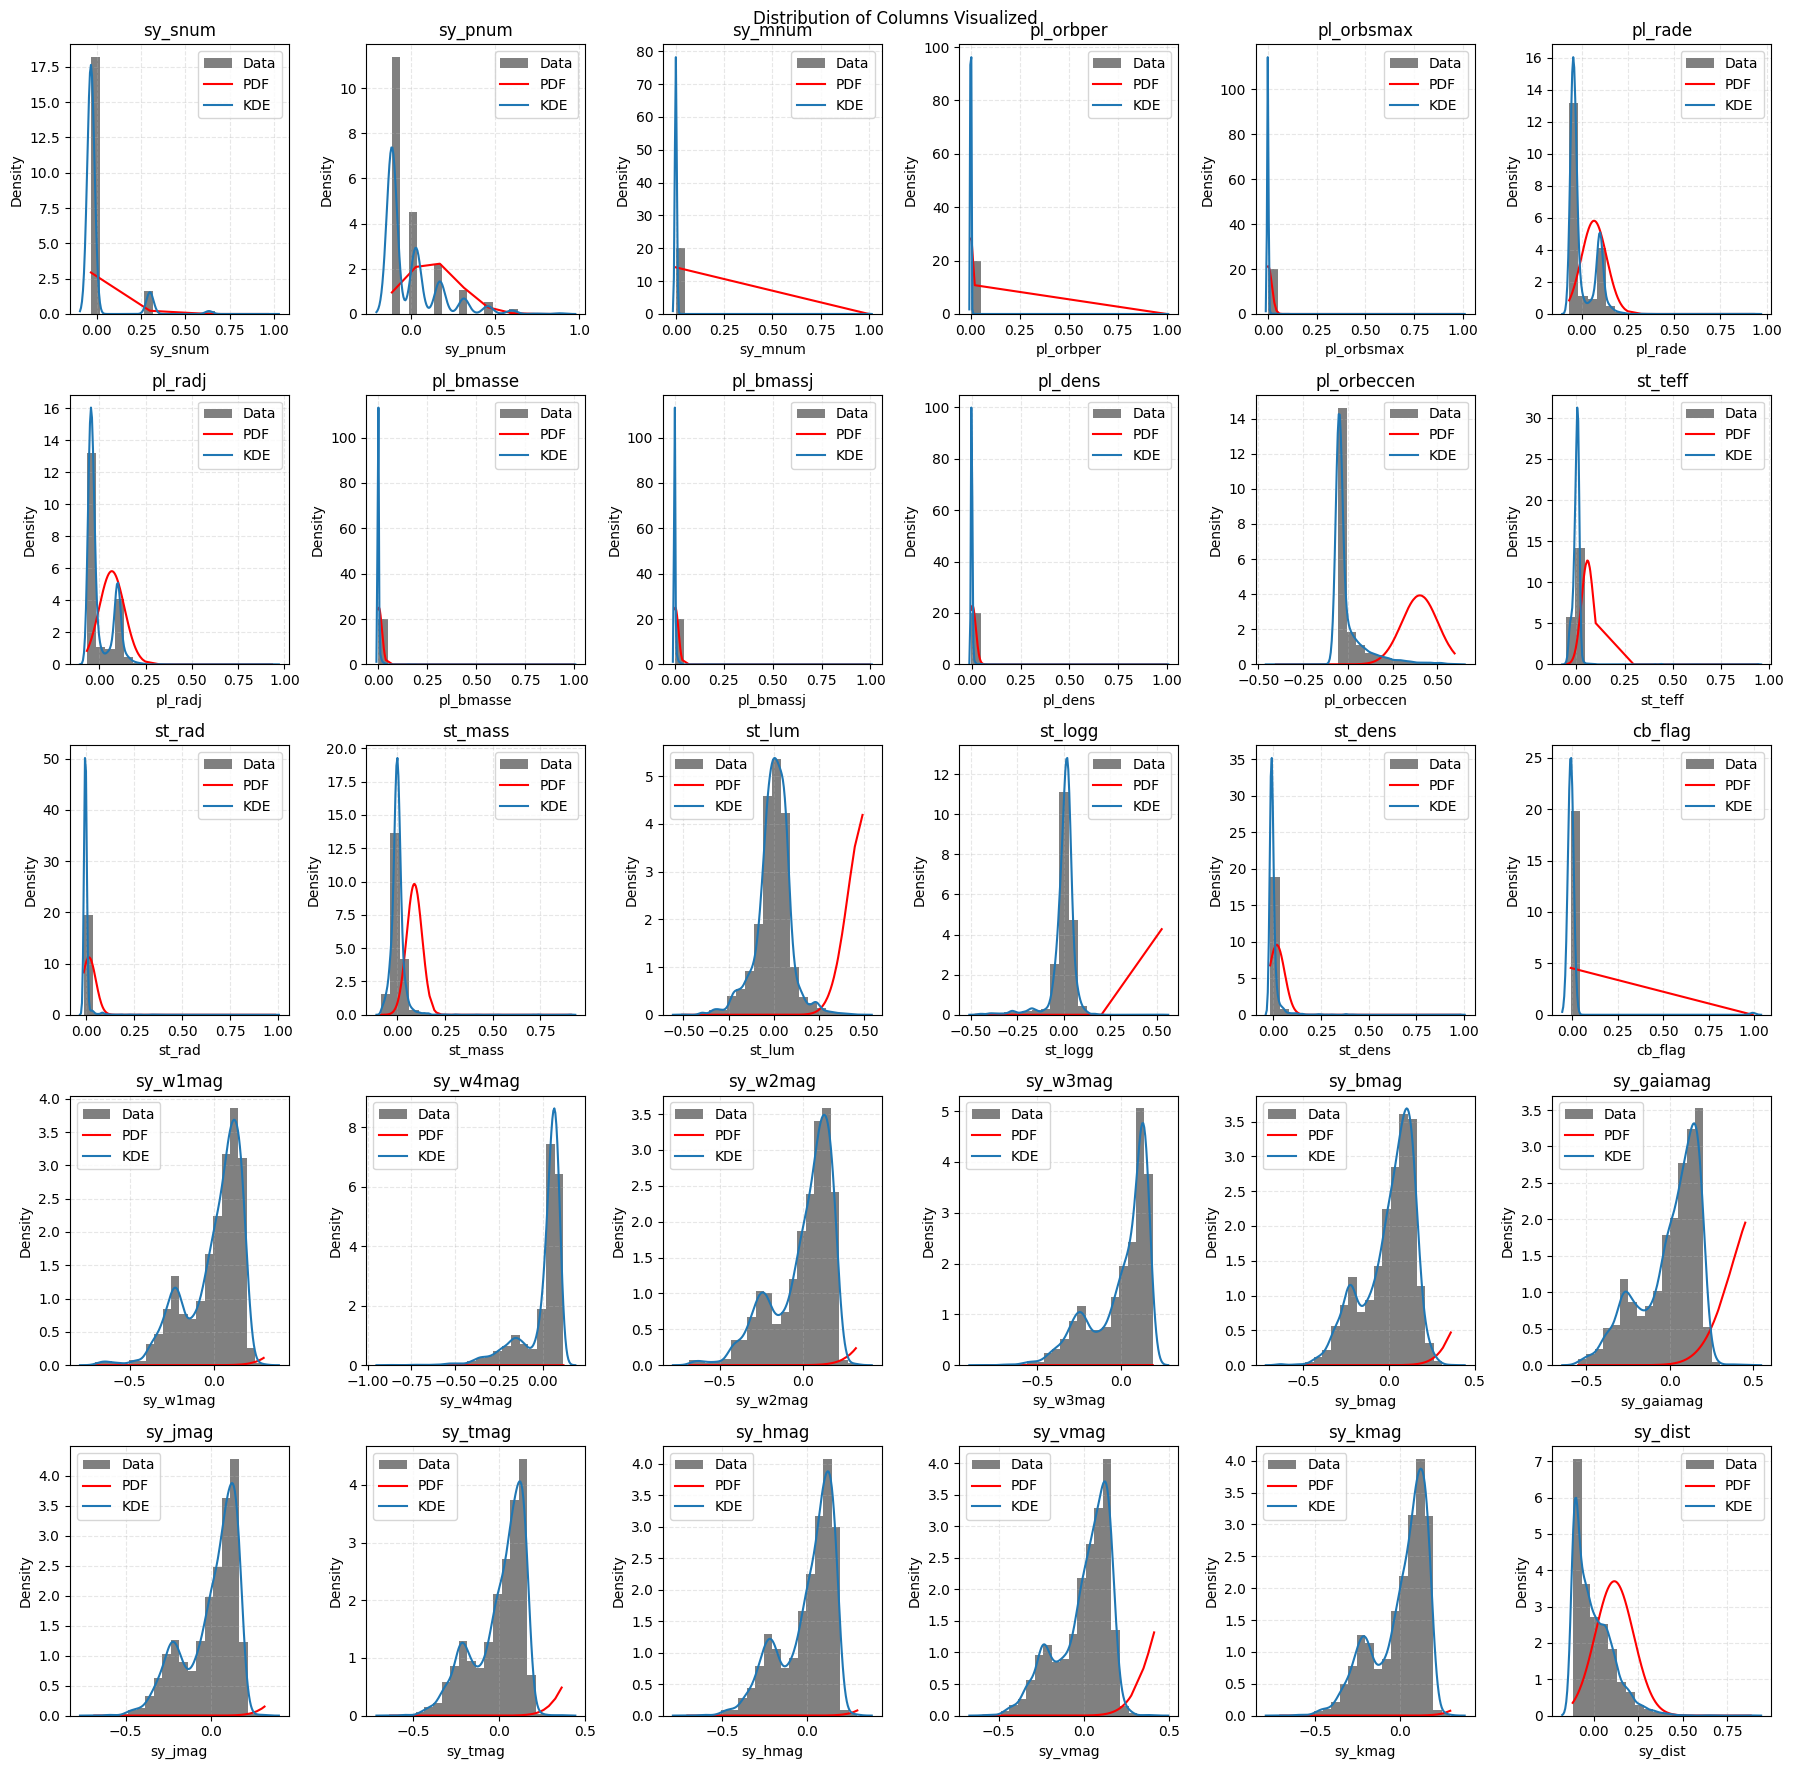

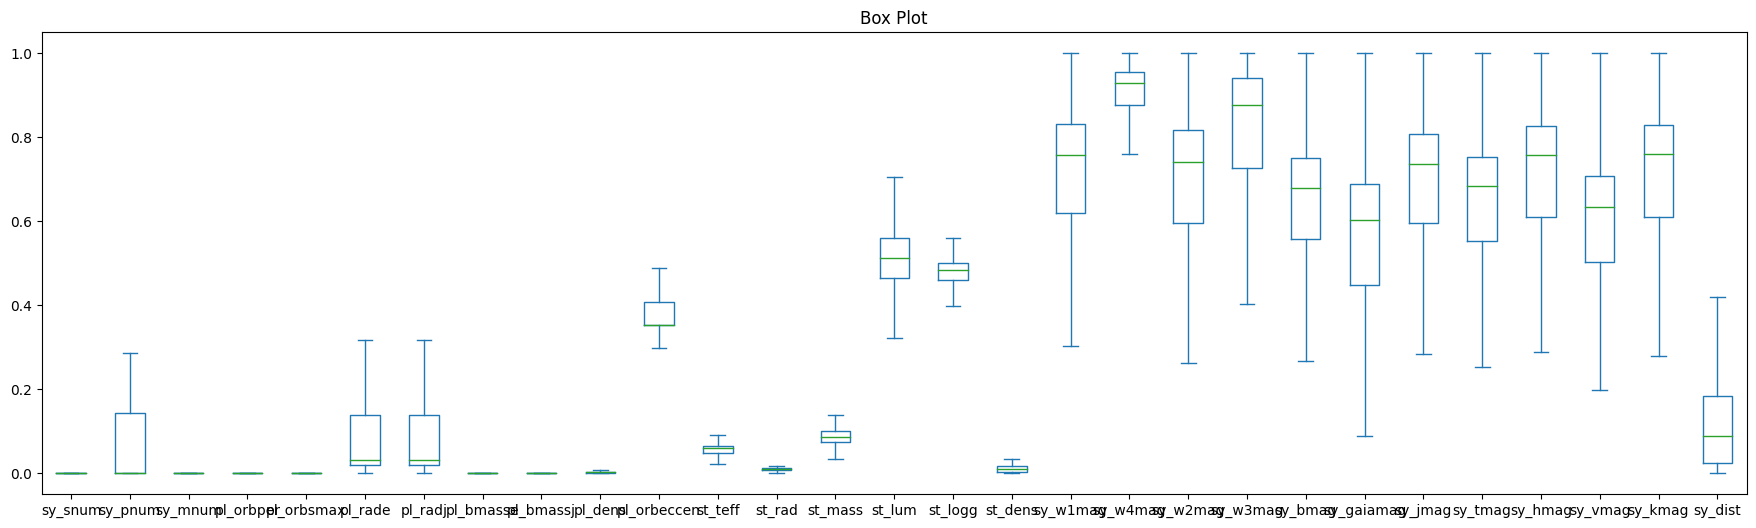

In [142]:
get_cols_info()

#### Using KNNImputation to fill the missing values, the optimal K value was found by K = sqrt(N) N being the number of rows in the data

In [143]:
imputer = KNNImputer(n_neighbors=70)
df = pd.DataFrame(imputer.fit_transform(df),columns = df.columns, index = df.index)

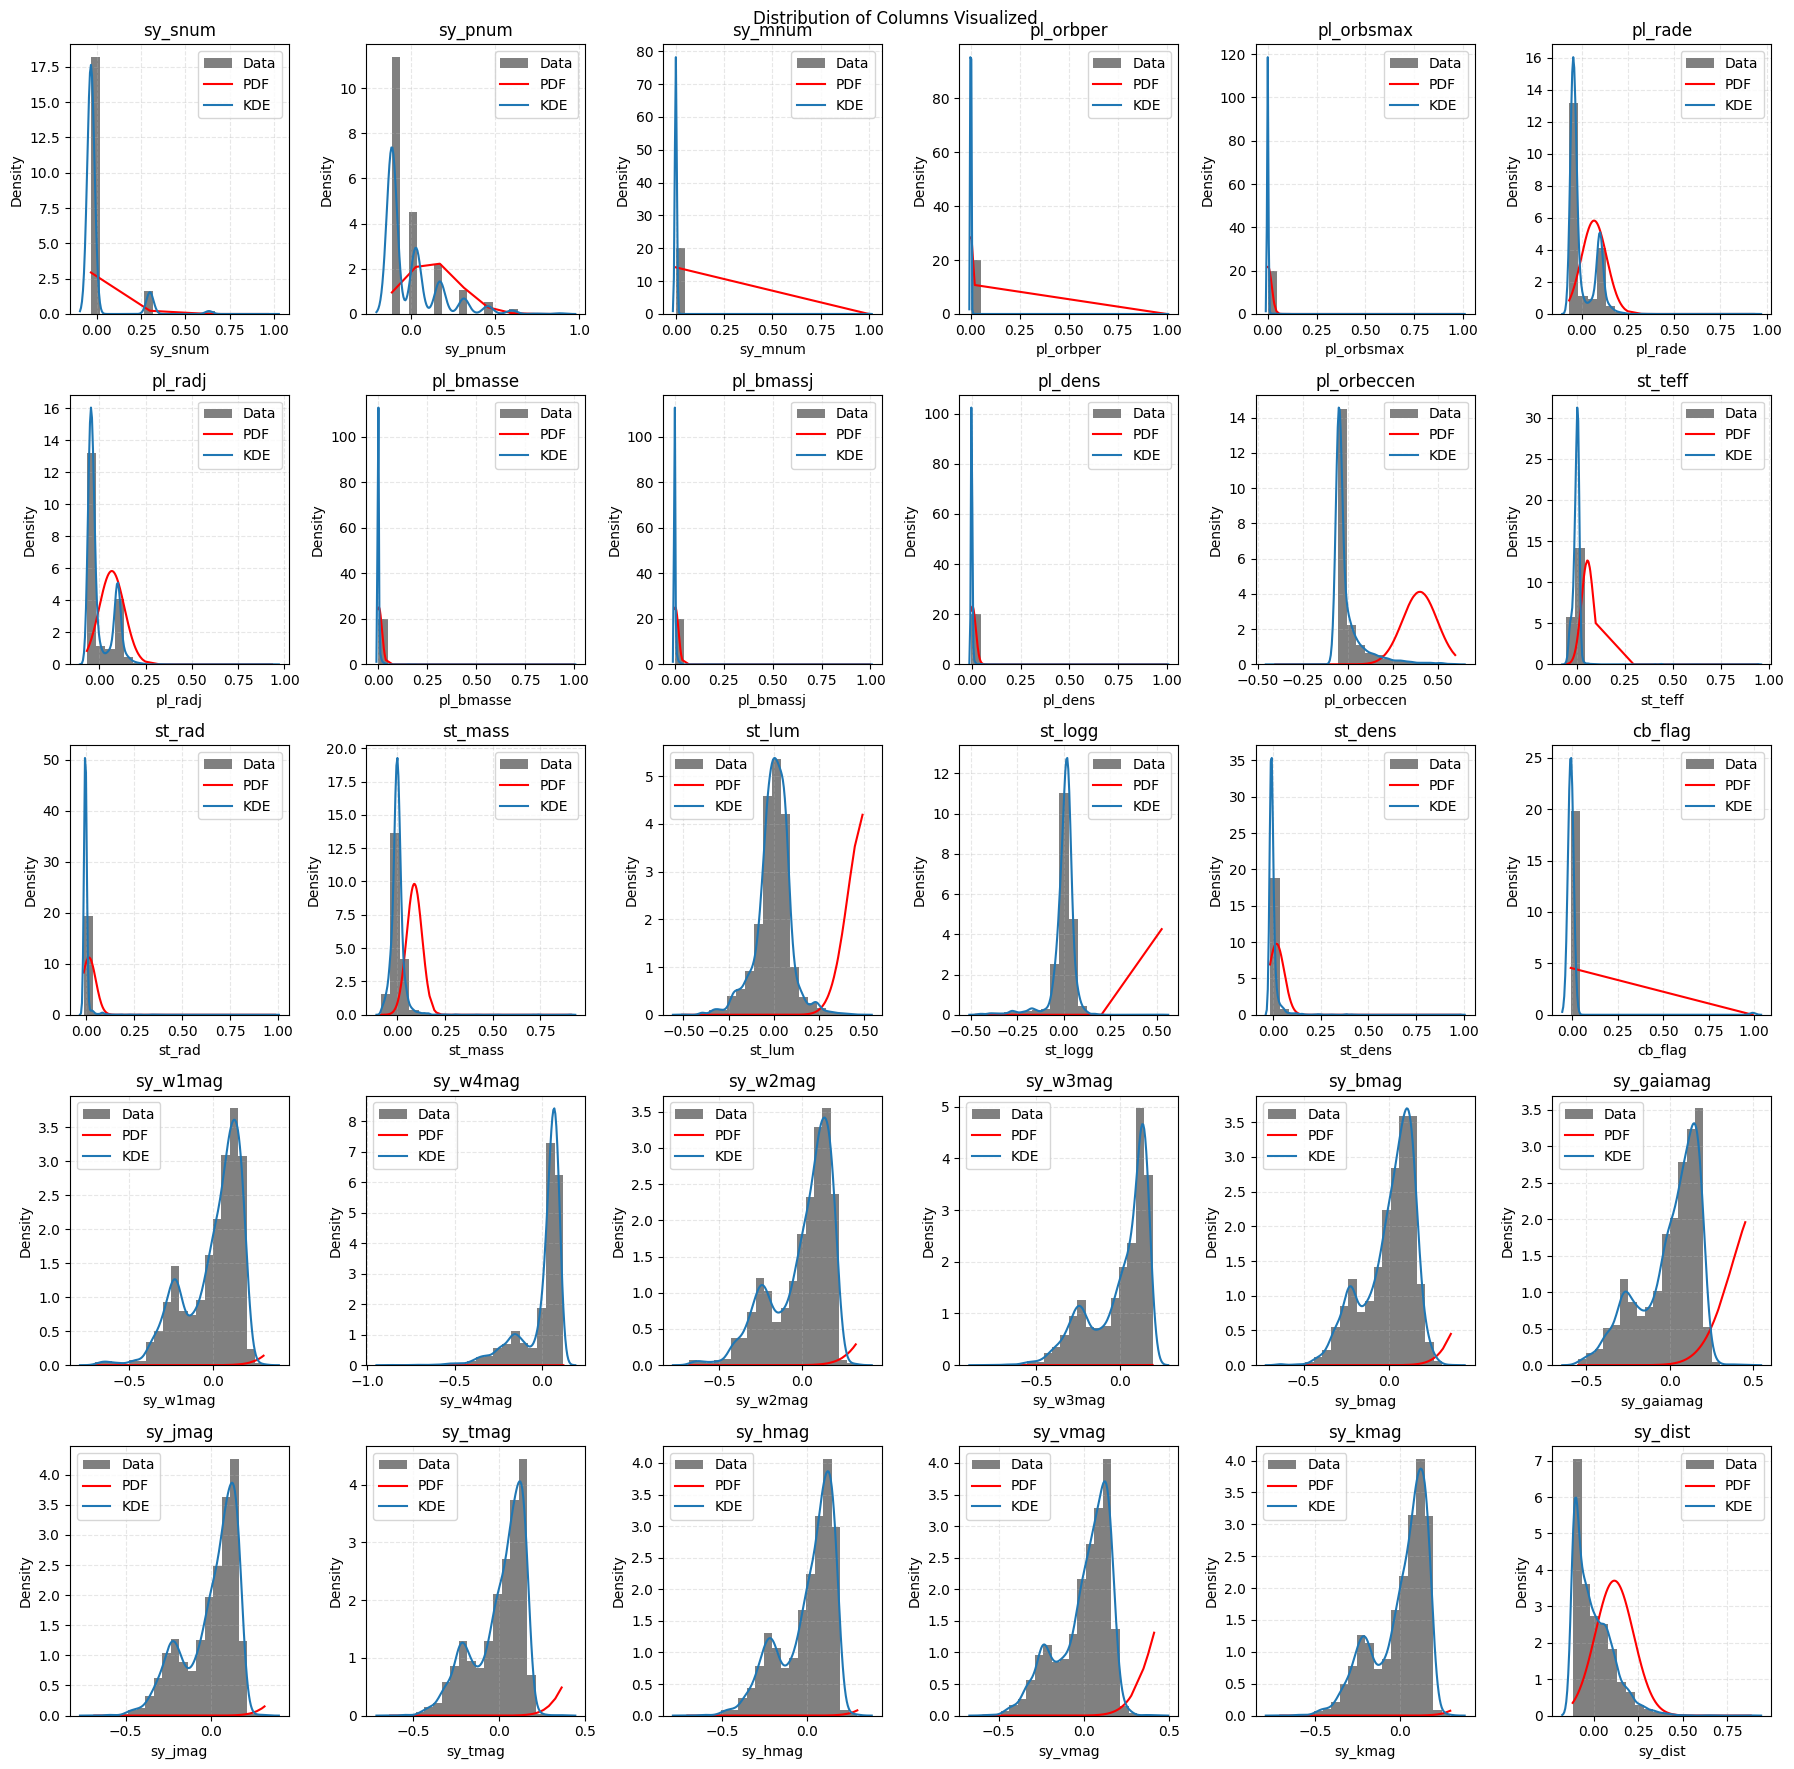

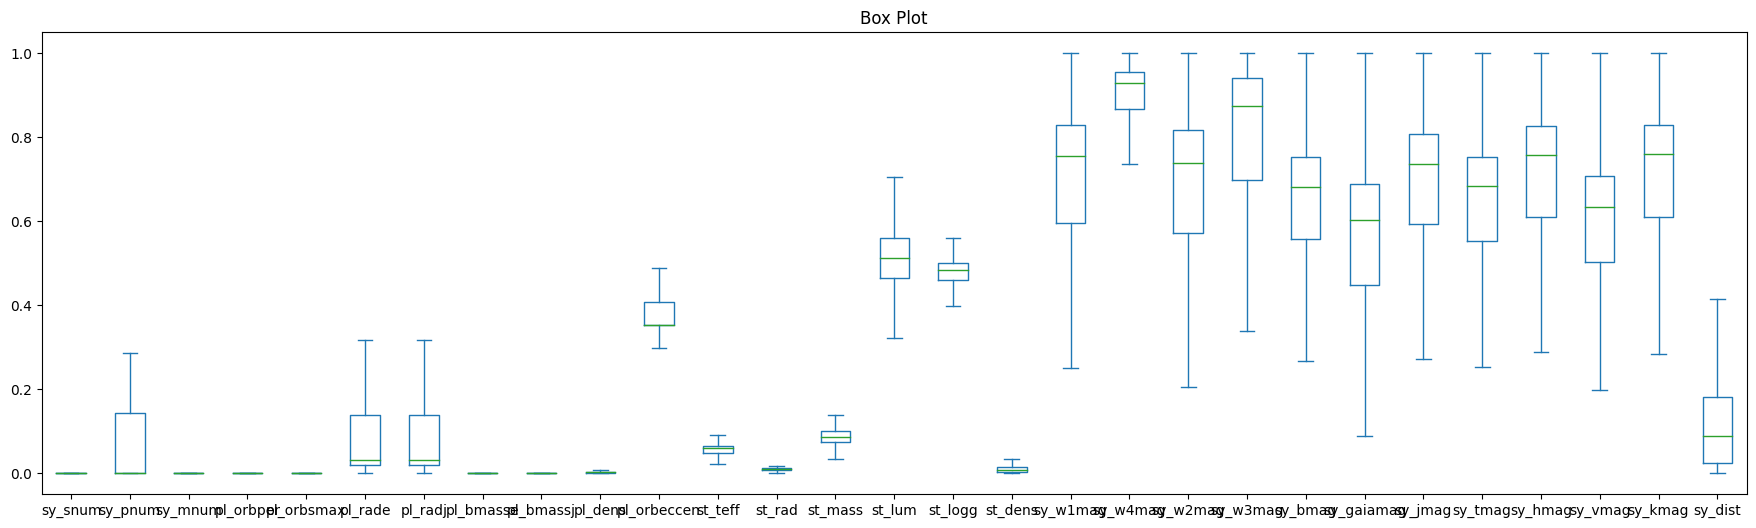

In [144]:
get_cols_info()

In [145]:
df.isnull().sum().to_frame()

,0
sy_snum,0
sy_pnum,0
sy_mnum,0
pl_orbper,0
pl_orbsmax,0
pl_rade,0
pl_radj,0
pl_bmasse,0
pl_bmassj,0
pl_dens,0


In [146]:
df.shape

(5080, 30)

### **Habitable Zone Calculations**

In [147]:
df = pd.DataFrame(scaler.inverse_transform(df), columns = df.columns, index=df.index)
df_habitable_zone = df.copy()

In [148]:
df_habitable_zone = df_habitable_zone[['pl_orbsmax','st_lum']]


In [149]:
df_habitable_zone['st_lum_norm'] = 10**df_habitable_zone['st_lum']

In [150]:
df_habitable_zone['st_lum_norm'].head()

0    174.984669
1    269.153480
2     57.942870
3      0.703072
4      1.250259
Name: st_lum_norm, dtype: float64

In [151]:
df_habitable_zone['min_distance'] = (df_habitable_zone['st_lum_norm']/1.1)**1/2
df_habitable_zone['max_distance'] = (df_habitable_zone['st_lum_norm']/0.53)**1/2

In [152]:
bigger_than_min = df_habitable_zone[df_habitable_zone['pl_orbsmax']>df_habitable_zone['min_distance']]
in_the_zone = bigger_than_min[bigger_than_min['pl_orbsmax']<bigger_than_min['max_distance']]
in_the_zone

,pl_orbsmax,st_lum,st_lum_norm,min_distance,max_distance
35,0.476000,-0.095,0.803526,0.365239,0.758044
45,0.064500,-1.046,0.089950,0.040886,0.084858
79,0.105500,-0.726,0.187932,0.085423,0.177294
113,0.402100,-0.254,0.557186,0.253266,0.525647
128,0.139446,-0.766,0.171396,0.077907,0.161694
...,...,...,...,...,...
5022,0.475600,-0.123,0.753356,0.342434,0.710713
5050,55.000000,1.830,67.608298,30.731044,63.781413
5069,0.243000,-0.305,0.495450,0.225205,0.467406
5073,2.513290,0.525,3.349654,1.522570,3.160051


In [153]:
in_the_zone['zone_width'] = in_the_zone['max_distance']-in_the_zone['min_distance']
in_the_zone['HZ_pos'] = (in_the_zone['pl_orbsmax']-in_the_zone['min_distance'])/ in_the_zone['zone_width']


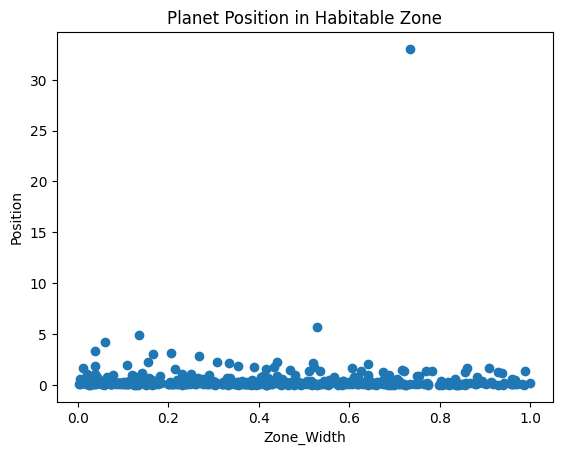

In [155]:
plt.scatter(in_the_zone['HZ_pos'],in_the_zone['zone_width'])
plt.title('Planet Position in Habitable Zone')
plt.ylabel('Position')
plt.xlabel('Zone_Width')
plt.show()

In [110]:
in_habitable = df.iloc[in_the_zone.index]

In [111]:
df['pl_zone_flag'] = 0
df.loc[in_the_zone.index,'pl_zone_flag'] = 1
df.loc[in_the_zone.index]

,sy_snum,sy_pnum,sy_mnum,pl_orbper,pl_orbsmax,pl_rade,pl_radj,pl_bmasse,pl_bmassj,pl_dens,...,sy_w3mag,sy_bmag,sy_gaiamag,sy_jmag,sy_tmag,sy_hmag,sy_vmag,sy_kmag,sy_dist,pl_zone_flag
35,1.0,3.0,0.0,123.010000,0.476000,5.110,0.456,22.90000,0.07200,0.943,...,3.091000,0.072000,4.540520,3.334000,4.085000,2.974000,4.695500,2.956000,8.503320,1
45,1.0,2.0,0.0,8.462999,0.064500,4.070,0.363,20.12000,0.06330,1.320,...,4.313000,10.209000,7.840380,5.436000,6.755000,4.831000,8.810000,4.529000,9.722100,1
79,1.0,1.0,0.0,13.240600,0.105500,10.870,0.970,874.00000,2.75000,3.700,...,11.396000,17.344000,14.664500,12.527000,13.821500,11.929000,15.293000,11.782000,338.386000,1
113,2.0,1.0,0.0,95.272656,0.402100,11.949,1.066,266.97720,0.84000,0.860,...,12.071000,14.558000,13.500800,12.175000,12.949700,11.813000,13.637000,11.688000,412.980000,1
128,1.0,1.0,0.0,2.131740,0.139446,0.692,0.062,0.26000,0.00082,4.310,...,11.354000,15.148000,13.736800,12.086000,13.070800,11.540000,13.948000,11.438000,253.026000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5022,2.0,3.0,0.0,120.800000,0.475600,13.600,1.210,435.40900,1.37000,0.951,...,9.272000,12.051000,10.927800,9.742000,10.416400,9.371000,11.196000,9.272000,151.398000,1
5050,1.0,1.0,0.0,1960.934546,55.000000,12.300,1.100,4327.36000,13.61600,12.800,...,4.400000,4.065000,4.134780,4.624000,4.224200,4.595000,4.137910,4.571000,50.017700,1
5069,1.0,4.0,0.0,49.410000,0.243000,1.190,0.106,1.83000,0.00576,5.970,...,4.077300,4.220000,3.248540,2.149000,2.745900,1.800000,3.496070,1.794000,3.603040,1
5073,2.0,3.0,0.0,1276.460000,2.513290,12.500,1.110,3257.74117,10.25000,9.170,...,2.853000,4.625000,3.986870,3.175000,3.613700,2.957000,4.095650,2.859000,13.405400,1


In [112]:
df = pd.DataFrame(scaler.fit_transform(df), columns = df.columns, index=df.index)

In [113]:
df.columns

Index(['sy_snum', 'sy_pnum', 'sy_mnum', 'pl_orbper', 'pl_orbsmax', 'pl_rade',
       'pl_radj', 'pl_bmasse', 'pl_bmassj', 'pl_dens', 'pl_orbeccen',
       'st_teff', 'st_rad', 'st_mass', 'st_lum', 'st_logg', 'st_dens',
       'cb_flag', 'sy_w1mag', 'sy_w4mag', 'sy_w2mag', 'sy_w3mag', 'sy_bmag',
       'sy_gaiamag', 'sy_jmag', 'sy_tmag', 'sy_hmag', 'sy_vmag', 'sy_kmag',
       'sy_dist', 'pl_zone_flag'],
      dtype='object')

In [42]:
df.shape

(5080, 31)

#### Separating columns related to planets or stars for further analysis

In [43]:
df_planets = df.loc[:,df.columns.str.startswith('pl')].copy() # for clustering only planet data
df_stellar = df.loc[:,df.columns.str.startswith('st')].copy() # for clustering only stellar data

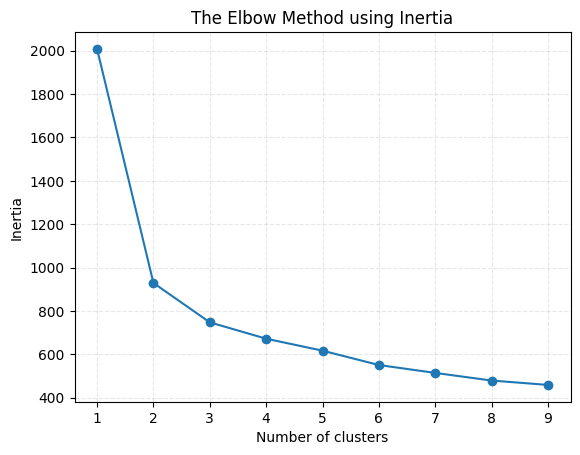

In [44]:
inertias = []
K = range(1, 10)
  
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(df)
    kmeanModel.fit(df)
    inertias.append(kmeanModel.inertia_)

plt.plot(K, inertias, 'o-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.grid(True, alpha=0.3, linestyle="--")
plt.show()

#### Performing PCA on default attributes

In [45]:
df.to_clipboard()

In [46]:
pca_data = PCA(n_components=0.95)
reduced_data = pca_data.fit_transform(df)
results_df = pd.DataFrame(reduced_data,index = df.index)
results_df.head()

,0,1,2,3,4,5,6,7
0,1.547404,-0.215448,-0.096772,0.188403,0.184028,-0.110716,-0.029210,0.266529
1,1.568655,-0.227139,-0.144823,0.246137,-0.126569,-0.105839,0.117213,0.301076
2,1.409305,-0.191878,-0.122318,0.165979,-0.110191,-0.130768,0.104700,0.163355
3,1.055059,0.015838,-0.042779,-0.039850,-0.063841,0.129973,0.002236,0.003471
4,1.132968,-0.132956,0.042077,-0.114636,0.533457,0.104407,-0.267197,0.085552


In [47]:
exp_var_pca_data = pca_data.explained_variance_ratio_
exp_var_pca_data

array([0.70350617, 0.07736967, 0.05456841, 0.04108133, 0.03406194,
       0.01885118, 0.01617128, 0.01393875])

### On planetary attributes

In [48]:
pca_planet = PCA(n_components=0.95)
reduced_data_planets = pca_planet.fit_transform(df_planets)
results_planets = pd.DataFrame(reduced_data_planets,index = df_planets.index)
results_planets.tail()

,0,1,2
5075,-0.008776,0.071953,0.132879
5076,0.926073,-0.327515,0.003932
5077,-0.042874,-0.082143,-0.027195
5078,-0.032360,-0.048220,-0.074565
5079,-0.007894,0.068373,0.083356


In [49]:
exp_var_pca_planet = pca_planet.explained_variance_ratio_
exp_var_pca_planet

array([0.52995581, 0.30621314, 0.13302984])

#### Performing PCA on stellar attributes

In [50]:
pca_stellar = PCA(n_components=0.95)
reduced_data_stellar = pca_stellar.fit_transform(df_stellar)
results_stellar = pd.DataFrame(reduced_data_stellar,index = df_stellar.index)
results_stellar.head()

,0,1,2,3
0,0.458983,0.134804,0.054309,0.028638
1,0.525214,0.207978,0.078917,0.039782
2,0.361616,0.098155,0.032373,-0.005898
3,-0.011991,-0.005785,-0.012492,-0.000954
4,0.024860,-0.014264,-0.009014,0.003556


In [51]:
exp_var_pca_stellar = pca_stellar.explained_variance_ratio_
exp_var_pca_stellar

array([0.72444571, 0.10657848, 0.08525501, 0.04382899])

### KMeans Clustering

**On default data**

In [52]:
kmeans = KMeans(n_clusters=3, n_init=100, max_iter=500) 
kmeans.fit(results_df)
y = kmeans.predict(results_df)
centers = kmeans.cluster_centers_

In [53]:
results_df['clusters'] = y 
results_df.head() 

,0,1,2,3,4,5,6,7,clusters
0,1.547404,-0.215448,-0.096772,0.188403,0.184028,-0.110716,-0.029210,0.266529,0
1,1.568655,-0.227139,-0.144823,0.246137,-0.126569,-0.105839,0.117213,0.301076,0
2,1.409305,-0.191878,-0.122318,0.165979,-0.110191,-0.130768,0.104700,0.163355,0
3,1.055059,0.015838,-0.042779,-0.039850,-0.063841,0.129973,0.002236,0.003471,0
4,1.132968,-0.132956,0.042077,-0.114636,0.533457,0.104407,-0.267197,0.085552,0


In [54]:
results_df.clusters.value_counts()

1    2623
2    1404
0    1053
Name: clusters, dtype: int64

**On planetary data**

In [55]:
kmeans = KMeans(n_clusters=3, n_init=100, max_iter=500) #n_init="auto" ne yapıyor tam olarak bak!!!
kmeans.fit(results_planets)
y = kmeans.predict(results_planets)
pl_centers = kmeans.cluster_centers_

In [56]:
results_planets['clusters'] = y
results_planets.head()

,0,1,2,clusters
0,0.019685,0.164686,0.007959,0
1,-0.000451,0.097387,0.083013,0
2,-0.009653,0.068080,0.129037,0
3,0.040117,0.234249,-0.056208,0
4,0.084330,0.385219,-0.195131,0


In [57]:
results_planets.clusters.value_counts()

1    3567
0    1402
2     111
Name: clusters, dtype: int64

**On stellar data**

In [58]:
kmeans = KMeans(n_clusters=3, n_init=100, max_iter=500) #n_init="auto" ne yapıyor tam olarak bak!!!
kmeans.fit(results_stellar)
y = kmeans.predict(results_stellar)
st_centers = kmeans.cluster_centers_

In [59]:
results_stellar['clusters'] = y
results_stellar.head()

,0,1,2,3,clusters
0,0.458983,0.134804,0.054309,0.028638,2
1,0.525214,0.207978,0.078917,0.039782,2
2,0.361616,0.098155,0.032373,-0.005898,2
3,-0.011991,-0.005785,-0.012492,-0.000954,0
4,0.024860,-0.014264,-0.009014,0.003556,0


In [60]:
results_stellar.clusters.value_counts()

0    3669
1    1199
2     212
Name: clusters, dtype: int64

In [61]:
results_habitable = results_df.iloc[in_habitable.index]
results_habitable

,0,1,2,3,4,5,6,7,clusters
31,1.206445,0.500652,0.886508,0.242453,0.097355,-0.205708,-0.073918,0.098921,0
48,0.589777,-0.067560,0.957181,0.100478,-0.159848,0.028186,-0.055709,-0.043233,0
55,0.557823,-0.062957,0.945880,0.111281,-0.163891,-0.063161,-0.029913,-0.055675,0
59,0.619274,-0.074406,0.950409,0.121793,-0.160258,0.015165,-0.051449,-0.040418,0
64,0.700074,0.117302,0.956430,0.025281,-0.189826,0.014524,-0.029685,0.033966,0
...,...,...,...,...,...,...,...,...,...
4776,0.219640,0.441507,0.945941,0.012928,-0.186858,-0.094927,-0.001294,0.050039,2
4800,-0.252652,0.903977,0.969343,-0.049230,-0.142216,0.016532,0.005041,0.081411,1
4942,0.209071,0.056864,0.957028,0.173762,-0.118671,0.077992,-0.088157,-0.099229,2
4949,0.132994,0.307039,0.927042,0.302388,-0.092976,0.126835,-0.101195,-0.080779,2


In [62]:
colors = ['#DF2020', '#81DF20', '#2095DF']
def plot_clusters(df: pd.DataFrame, title: str, centers) -> pd.DataFrame:
    results_df['c'] = df['clusters'].map({0: colors[0], 1: colors[1], 2: colors[2]})

    fig = plt.gcf()
    fig.set_size_inches(16,9)
    sns.scatterplot(x=0, y=1, hue=df['clusters'], data=df, alpha=0.5, palette=colors)
    plt.title(title)


    pca1 = df[0]
    pca2 = df[1]
    # plot pca1 mean
    plt.plot([pca1.mean()] * 2, [-pca1.max(),pca1.max()], color='black', lw=0.5, linestyle='--')
    # plot pca2 mean
    plt.plot([-pca2.max(),pca2.max()], [pca2.mean()]*2, color='black', lw=0.5, linestyle='--')
    
    for i in df.clusters.unique():
        # get the convex hull
        points = df[df.clusters == i][[0,1]].values
        hull = ConvexHull(points)
        x_hull = np.append(points[hull.vertices,0],
                        points[hull.vertices,0][0])
        y_hull = np.append(points[hull.vertices,1],
                        points[hull.vertices,1][0])
        
        # interpolate
        dist = np.sqrt((x_hull[:-1] - x_hull[1:])**2 + (y_hull[:-1] - y_hull[1:])**2)
        dist_along = np.concatenate(([0], dist.cumsum()))
        spline, u = interpolate.splprep([x_hull, y_hull], 
                                        u=dist_along, s=0, per=1)
        interp_d = np.linspace(dist_along[0], dist_along[-1], 50)
        interp_x, interp_y = interpolate.splev(interp_d, spline)
        # plot shape
        plt.fill(interp_x, interp_y, '--', c=colors[i], alpha=0.2)

    # create a list of legend elemntes
    ## average line
    legend_elements = [Line2D([0], [0], color='black', lw=0.5, linestyle='--', label='Average')]
    ## markers / records
    cluster_leg = [Line2D([0], [0], marker='o', color='w', label='Cluster {}'.format(i+1), 
                markerfacecolor=mcolor, markersize=5) for i, mcolor in enumerate(colors)]
    ## centroids
    cent_leg = [Line2D([0], [0], marker='^', color='w', label='Centroid - C{}'.format(i+1), 
                markerfacecolor=mcolor, markersize=10) for i, mcolor in enumerate(colors)]
    # add all elements to the same list
    legend_elements.extend(cluster_leg)
    legend_elements.extend(cent_leg)
    # plot legend

    e_index = label_df[label_df['pl_name'] == 'Earth'].index
    m_index = label_df[label_df['pl_name'] == 'Mars'].index
    v_index = label_df[label_df['pl_name'] == 'Venus'].index
    j_index = label_df[label_df['pl_name'] == 'Jupiter'].index
    # First one below is in the habitable zone and second one below is not in habitable zone
    t_index = label_df[label_df['pl_name'] == 'TRAPPIST-1 g'].index
    b_index = label_df[label_df['pl_name'] == 'tau Boo b'].index
    t2_index = label_df[label_df['pl_name'] == 'TRAPPIST-1 d'].index
    t3_index = label_df[label_df['pl_name'] == 'TRAPPIST-1 e'].index

    e_cluster = df.iloc[e_index].clusters.values[0]

    plt.scatter(centers[:, 0], centers[:, 1], c=colors, marker = '^', s=100,edgecolors= "black")

    plt.scatter(df.iloc[e_index][0],df.iloc[e_index][1], c='darkblue',edgecolors= "black")
    plt.scatter(df.iloc[m_index][0],df.iloc[m_index][1], c='orange',edgecolors= "black")
    plt.scatter(df.iloc[v_index][0],df.iloc[v_index][1], c='lightblue',edgecolors= "black")
    plt.scatter(df.iloc[j_index][0],df.iloc[j_index][1], c='yellow',edgecolors= "black")
    plt.scatter(df.iloc[t_index][0],df.iloc[t_index][1], c='green',edgecolors= "black")
    plt.scatter(df.iloc[b_index][0],df.iloc[b_index][1], c='purple',edgecolors= "black")
    plt.scatter(df.iloc[t2_index][0],df.iloc[t2_index][1], c='magenta',edgecolors= "black")
    plt.scatter(df.iloc[t3_index][0],df.iloc[t3_index][1], c='cyan',edgecolors= "black")

    legend_elements.extend([Line2D([0], [0], marker='o', color='w', label=name, mec = 'black',
                markerfacecolor=color, markersize=10) for name, color in {'Earth':'darkblue',
                'Mars':'orange','Venus':'lightblue','Jupiter':'yellow','TRAPPIST-1 g':'green','tau Boo b':'purple',
                'TRAPPIST-1 d':'magenta','TRAPPIST-1 e':'cyan'}.items()])


    plt.legend(handles=legend_elements, loc='upper right', ncol=2)
    plt.show()
    return_df = label_df.iloc[df[df['clusters'] == e_cluster].index]
    return_df = return_df.drop(index=e_index)
    return return_df

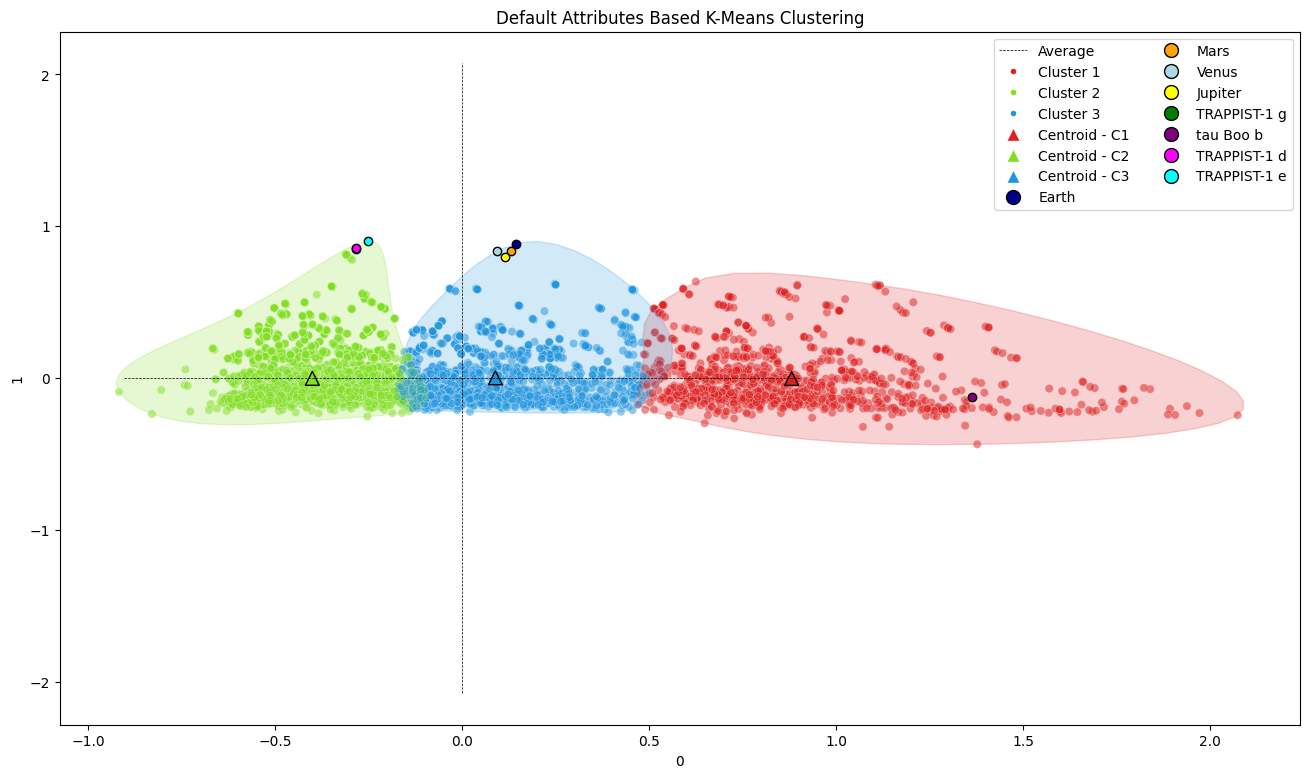

In [63]:
overall_clustered = plot_clusters(results_df,'Default Attributes Based K-Means Clustering',centers)

In [64]:
overall_clustered

,pl_name,hostname
7,1RXS J160929.1-210524 b,1RXS J160929.1-210524
11,2M0437 b,2MASS J04372171+2651014
12,2MASS J01033563-5515561 AB b,2MASS J01033563-5515561 A
13,2MASS J01225093-2439505 b,2MASS J01225093-2439505
14,2MASS J02192210-3925225 b,2MASS J02192210-3925225
...,...,...
5030,YZ Cet c,YZ Cet
5031,YZ Cet d,YZ Cet
5077,Venus,Sol
5078,Mars,Sol


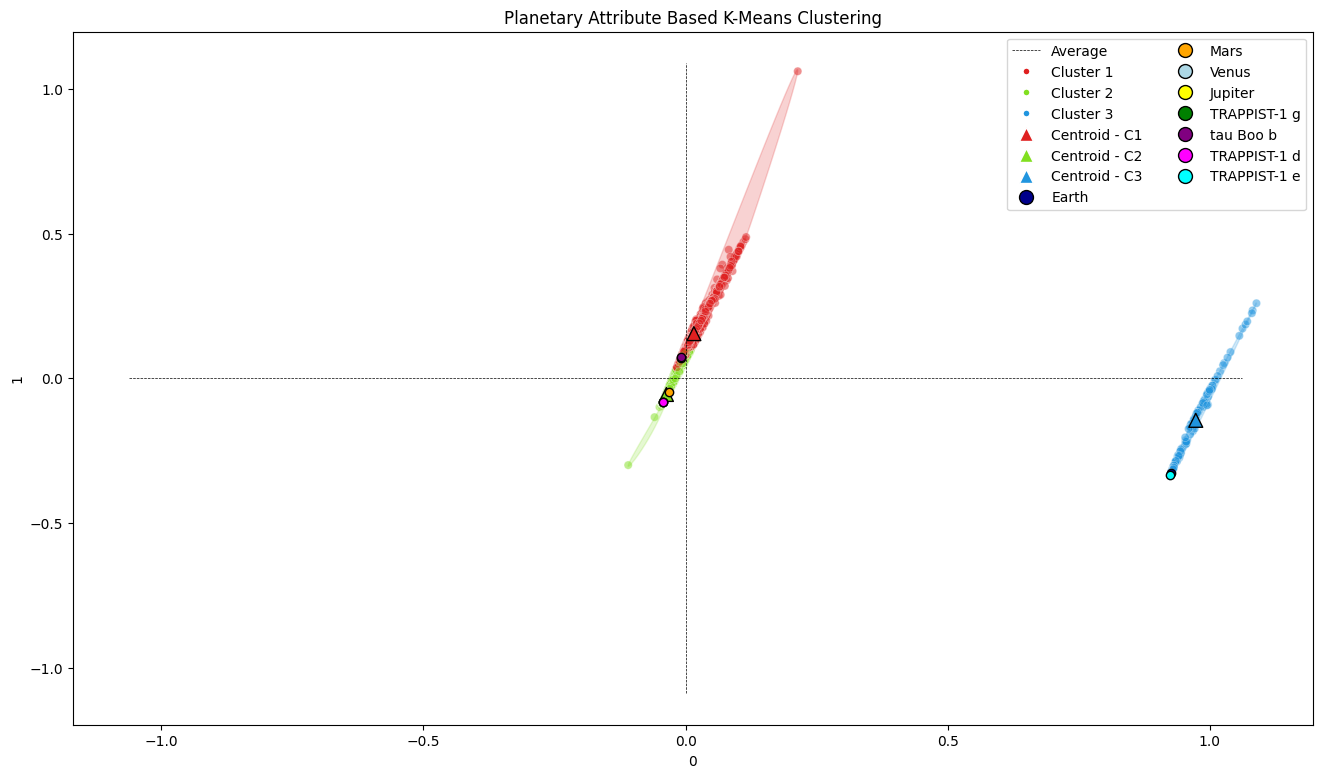

In [65]:
pl_clustered = plot_clusters(results_planets, 'Planetary Attribute Based K-Means Clustering', pl_centers)

In [66]:
pl_clustered.to_clipboard()

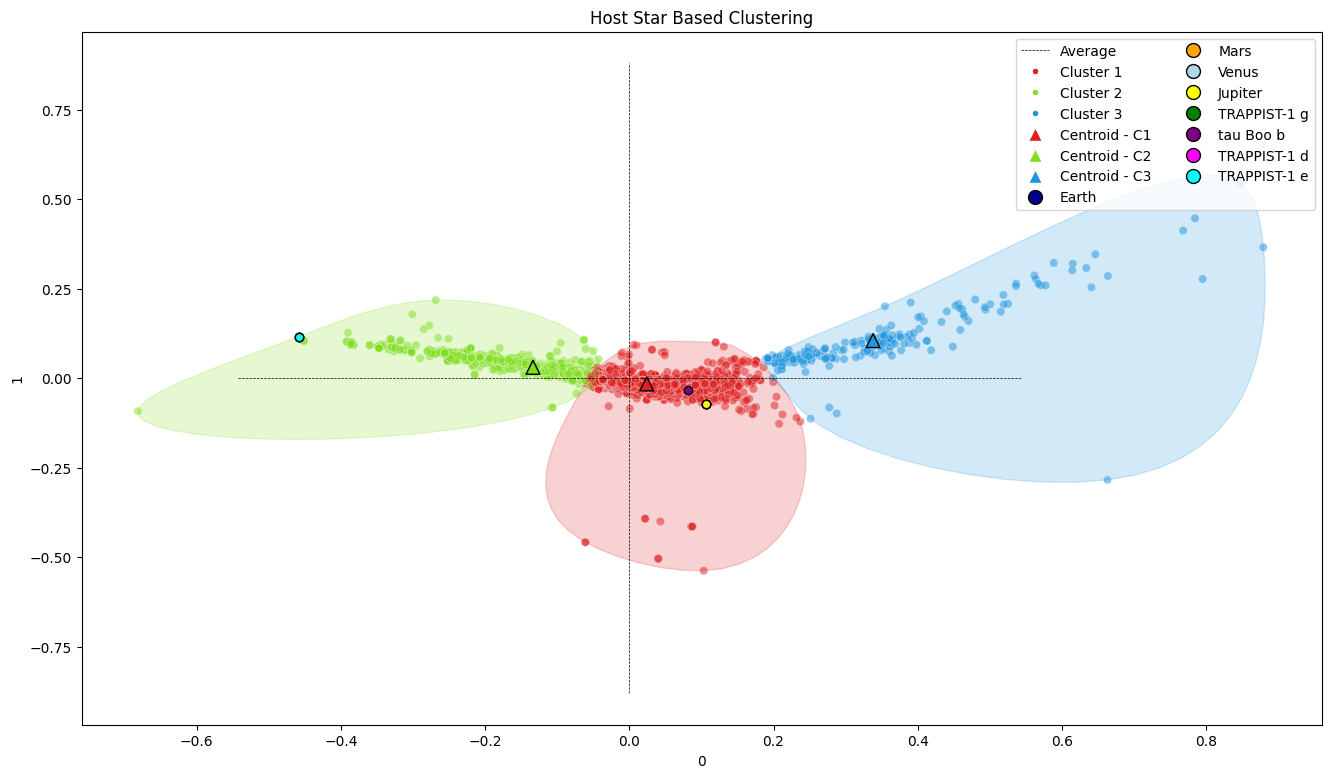

In [67]:
st_clustered = plot_clusters(results_stellar, 'Host Star Based Clustering', st_centers)

In [68]:
st_clustered

,pl_name,hostname
3,14 Her b,14 Her
4,16 Cyg B b,16 Cyg B
7,1RXS J160929.1-210524 b,1RXS J160929.1-210524
17,2MASS J19383260+4603591 b,2MASS J19383260+4603591
19,30 Ari B b,30 Ari B
...,...,...
5072,ups And c,ups And
5073,ups And d,ups And
5077,Venus,Sol
5078,Mars,Sol


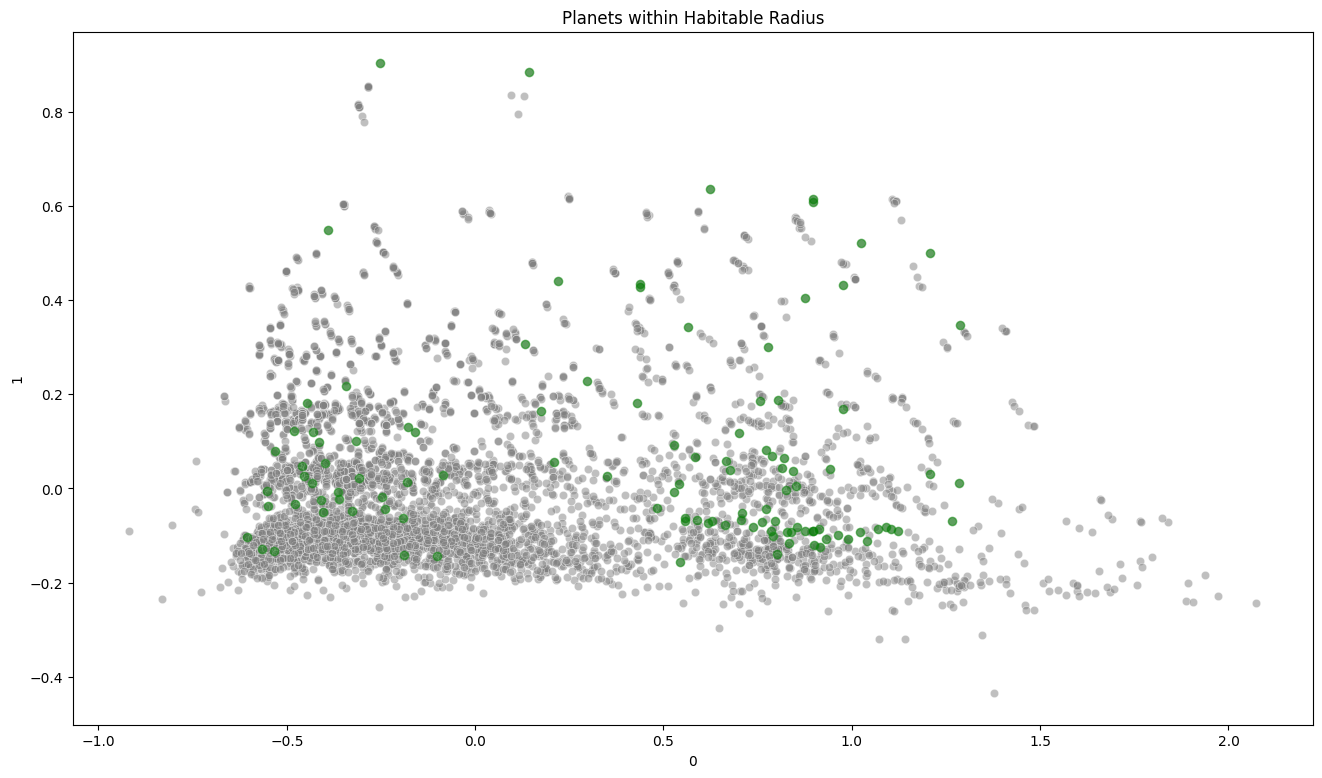

In [69]:
# scatter plot of distribution of planets in habitable zone among all other planets
fig = plt.gcf()
fig.set_size_inches(16,9)
sns.scatterplot(x=0, y=1, data=results_df, alpha=0.5, color = 'gray')
plt.title('Planets within Habitable Radius')

plt.scatter(results_habitable[0],results_habitable[1], c='green', alpha=0.5)

plt.show()

In [70]:
final_df = pl_clustered
final_df

,pl_name,hostname
31,55 Cnc f,55 Cnc
48,BD+14 4559 b,BD+14 4559
55,BD+45 564 b,BD+45 564
59,BD+55 362 b,BD+55 362
64,BD-06 1339 c,BD-06 1339
...,...,...
4703,TOI-2257 b,TOI-2257
4776,TOI-700 d,TOI-700
4800,TRAPPIST-1 e,TRAPPIST-1
4942,WASP-41 c,WASP-41


In [71]:
final_df = pd.concat([final_df, st_clustered], axis=1, join='inner')
final_df

,pl_name,hostname,pl_name,hostname
31,55 Cnc f,55 Cnc,55 Cnc f,55 Cnc
48,BD+14 4559 b,BD+14 4559,BD+14 4559 b,BD+14 4559
55,BD+45 564 b,BD+45 564,BD+45 564 b,BD+45 564
59,BD+55 362 b,BD+55 362,BD+55 362 b,BD+55 362
450,HD 100777 b,HD 100777,HD 100777 b,HD 100777
...,...,...,...,...
3791,Kepler-47 c,Kepler-47,Kepler-47 c,Kepler-47
3914,Kepler-553 c,Kepler-553,Kepler-553 c,Kepler-553
4086,Kepler-68 d,Kepler-68,Kepler-68 d,Kepler-68
4942,WASP-41 c,WASP-41,WASP-41 c,WASP-41


In [72]:
final_df = pd.concat([final_df, overall_clustered], axis=1, join='inner')
final_df

,pl_name,hostname,pl_name,hostname,pl_name,hostname
1762,KELT-6 c,KELT-6,KELT-6 c,KELT-6,KELT-6 c,KELT-6
2764,Kepler-1704 b,Kepler-1704,Kepler-1704 b,Kepler-1704,Kepler-1704 b,Kepler-1704
4086,Kepler-68 d,Kepler-68,Kepler-68 d,Kepler-68,Kepler-68 d,Kepler-68
4942,WASP-41 c,WASP-41,WASP-41 c,WASP-41,WASP-41 c,WASP-41
4949,WASP-47 c,WASP-47,WASP-47 c,WASP-47,WASP-47 c,WASP-47
